In [15]:
import numpy as np
import pandas as pd
import datetime as dt
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [25]:
def price_Nyears_ago(tickers, interval, N):
    end = dt.datetime.now()
    start = end - dt.timedelta(weeks=52*N)
    frequency = {'1d':252, '1wk':52, '1mo': 12}
    frequency = frequency[interval]
    stock_df = yf.download(tickers, start=start, end=end, interval=interval, progress=False)['Adj Close']
    return stock_df

# 5 years, monthly
N = 10
interval='1mo'
tickers = ['VOO','TLT']
stock_df = price_Nyears_ago(tickers, interval, N)

Mean: 0.36 Median: 0.64 Mode: 0.91


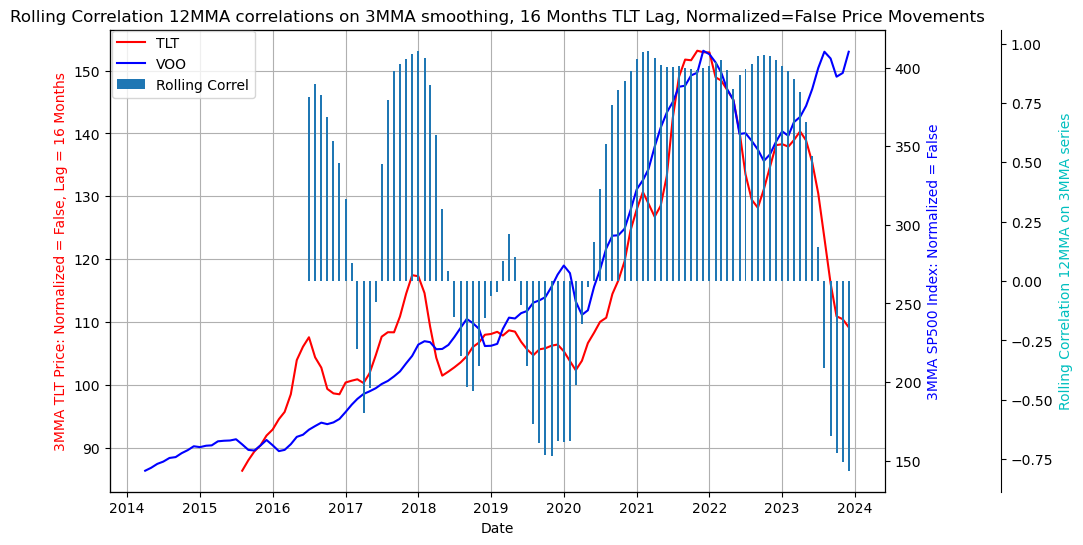

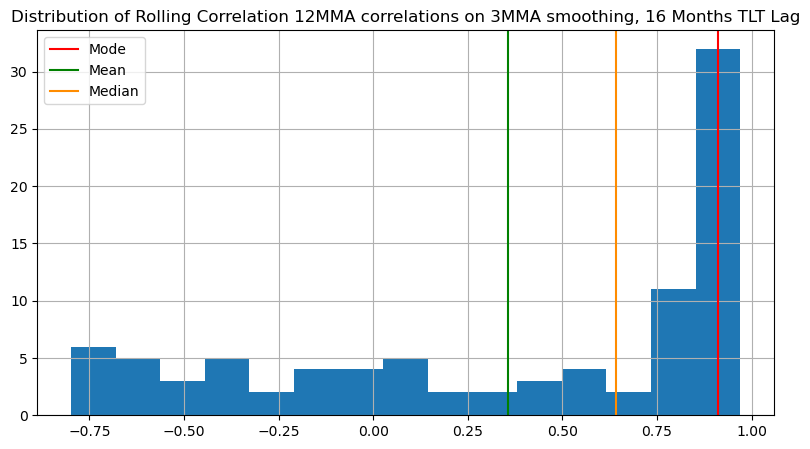

In [26]:
# lag leading indicator (bond) to match stock market, as bond market tend to precede equity market
# Normalized must be False to lag series
lag = 16
SP500 = stock_df['VOO']
TLT = stock_df['TLT'].shift(lag)

# lag must = 0 to Normalize series 
if lag ==0:
    Normalized = True
    # Normalized price
    SP500 = SP500/SP500.iloc[0]
    TLT = TLT/TLT.iloc[0]
else: 
    Normalized = False

# Series Monthly Moving Average Window, to smooth the time series
ma = 3
SP500 = SP500.rolling(ma).mean()
TLT = TLT.rolling(ma).mean()

# Monthly Rolling Correlation Window
# Rolling Correlation taken on MMA Series, not original series 
width = 12
rollingcorr = stock_df['VOO'].rolling(width).corr(stock_df['TLT'])
rollingcorr = SP500.rolling(width).corr(TLT)

# Graph Rolling Correlation
fig, ax1 = plt.subplots(figsize=(10, 6), dpi=100)
plt.title(f'Rolling Correlation {width}MMA correlations on {ma}MMA smoothing, {lag} Months TLT Lag, Normalized={Normalized} Price Movements')
plt.grid()
ax2 = ax1.twinx()
ax3 = ax1.twinx()
ax3.spines.right.set_position(("axes", 1.15))

ax1.plot(TLT.index, TLT, color='r', label='TLT')
ax2.plot(SP500.index, SP500, color='b', label='VOO')
ax3.bar(rollingcorr.index, rollingcorr, width=10, label='Rolling Correl')

ax1.set_xlabel('Date')
ax1.set_ylabel(f'{ma}MMA TLT Price: Normalized = {Normalized}, Lag = {lag} Months', color='r')
ax2.set_ylabel(f'{ma}MMA SP500 Index: Normalized = {Normalized}', color='b')
ax3.set_ylabel(f'Rolling Correlation {width}MMA on {ma}MMA series', color='c')

fig.legend(bbox_to_anchor=(0.12, 0.89), loc="upper left")

# Histogram of rolling correlations
plt.figure(figsize=(9.5, 5), dpi=100)
plt.title(f'Distribution of Rolling Correlation {width}MMA correlations on {ma}MMA smoothing, {lag} Months TLT Lag')
plt.grid()
n, bins, patches = plt.hist(rollingcorr,bins = 15);
modeindex = n.argmax()
modebin_low = bins[modeindex]
modebin_high = bins[modeindex+1]
bin_mode = (modebin_low+modebin_high)/2

plt.axvline(bin_mode, color='red', label='Mode')
plt.axvline(rollingcorr.mean(), color='green', label='Mean')
plt.axvline(rollingcorr.median(), color='darkorange', label='Median')
plt.legend()

print('Mean:', round(rollingcorr.mean(),2),
      'Median:',round(rollingcorr.median(),2),
      'Mode:',round(bin_mode,2))

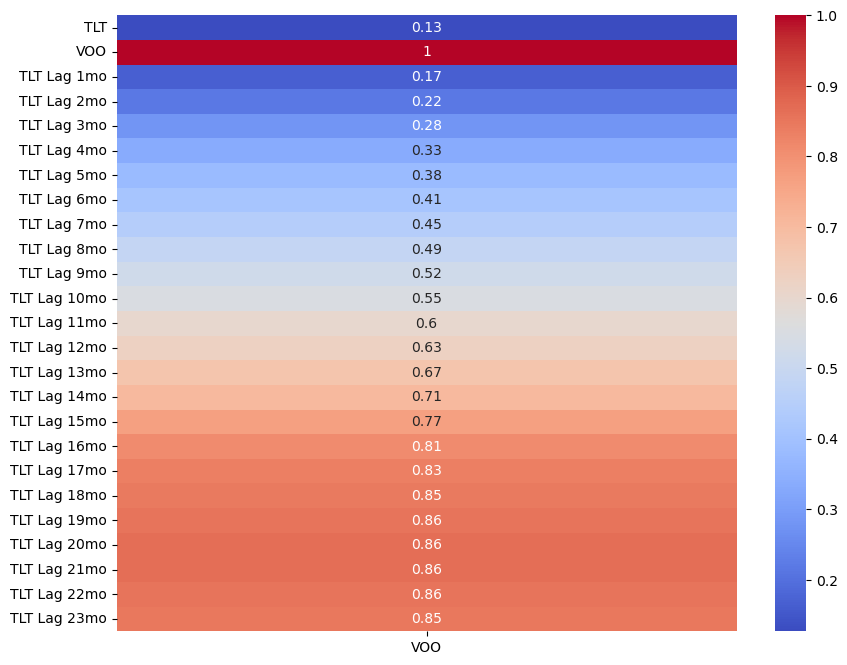

In [27]:
for lag in range(1,24): # 1~18mo lags
    stock_df[f'TLT Lag {lag}mo'] = stock_df['TLT'].shift(lag)

stock_df = stock_df.dropna()

plt.figure(figsize=(10,8))
corr = stock_df.corr()
sns.heatmap(corr[['VOO']], cmap='coolwarm', annot=True);

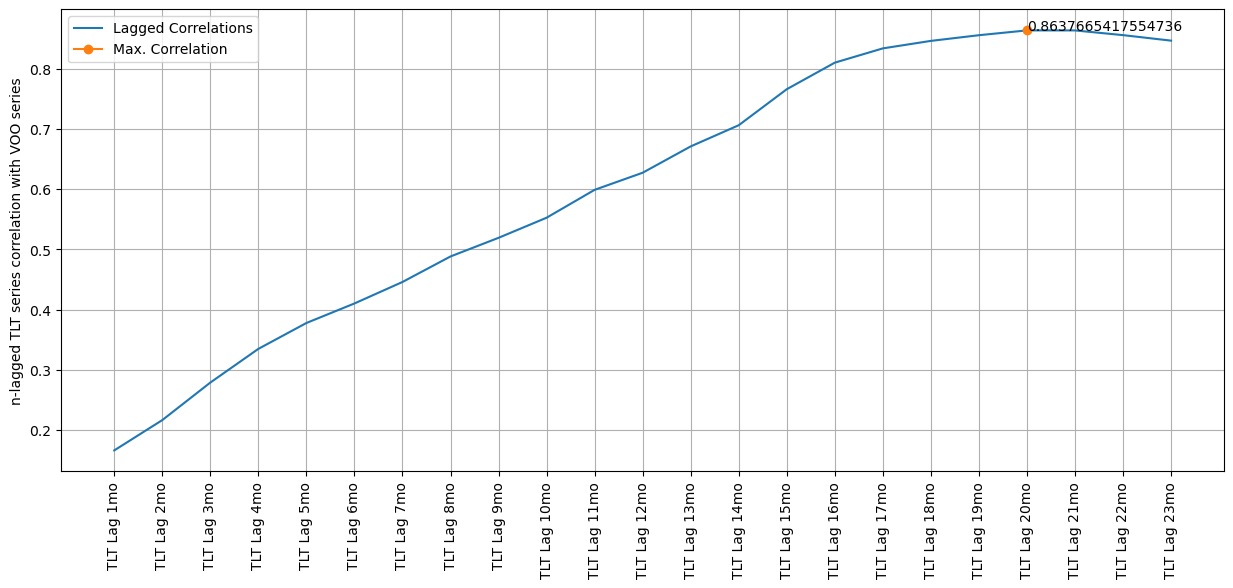

In [28]:
lag_correls = corr[['VOO']].iloc[2:]
max_idx = np.argmax(lag_correls)
corr_max = lag_correls.iloc[max_idx]

plt.figure(figsize=(15,6))
ax = plt.axes()
plt.grid()
plt.plot(lag_correls, label='Lagged Correlations')
plt.plot(max_idx, corr_max, marker='o', label='Max. Correlation')
plt.text(max_idx, corr_max, s=corr_max[0])
plt.setp(ax.get_xticklabels(), rotation=90, horizontalalignment='center')
plt.ylabel('n-lagged TLT series correlation with VOO series')
plt.legend();